### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys

## Data loading

In [2]:
# Unzip train_data.npy, test_data.npy, val_data.npy
!unzip all_data.zip

# Load the data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')
val_data = np.load('val_data.npy')

'unzip' is not recognized as an internal or external command,
operable program or batch file.


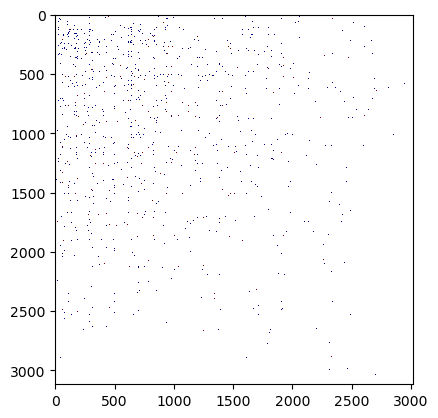

In [3]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

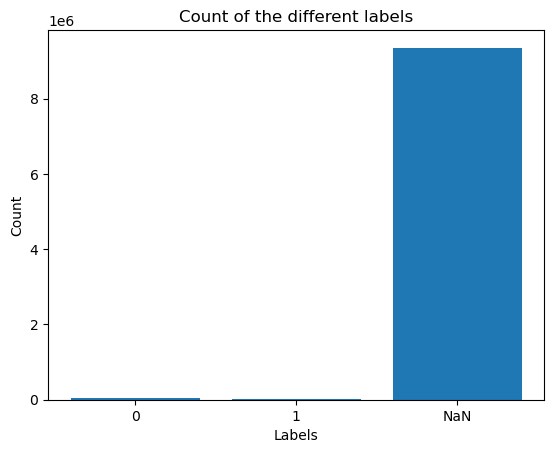

Number of likes: 50298
Number of dislikes: 10897
Number of NaNs: 9348929


In [4]:
flat  = train_data.flatten()

unique, counts = np.unique(flat, return_counts=True)

labels = ['0','1','NaN']
plt.bar(labels, counts)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of the different labels')
plt.show()

print("Number of likes: " + str(counts[0]))
print("Number of dislikes: " + str(counts[1]))
print("Number of NaNs: " + str(counts[2]))

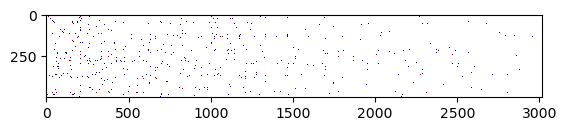

In [5]:
first_500 = train_data[:500][:500]

cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(first_500, mask=np.isnan(first_500))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

In [6]:
# Further visualizations to justify your answers to the familiarization questions below

**Familiarization questions**

1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

We do not want out data to be sparse because this would introduce a data imputation problem, which increases the reconstruction error. In other words, we would not recommend more desirable companions to our users. This can be seen from the plot above, since although there are 3000 users, most of the graph is blank as each point is a user interaction with another. 

For the distribution of labels, as you can see from the second plot above, we have 50298 likes, 10897 dislikes and 9348929 NaN, from this we can see that the distribution of our labels is very uneven and further shows that our graph is sparse since most of the data is made up of NaNs.


2.	What are some sources of sparsity in the data?

For example, some users might be more active on the application that others, meaning they would have more interactions with other users. There might also be some filters such as distances, gender and age etc. which would provide more options to a specific user than other users.


3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

On the top left of the first plot, we can see a lot of interactions. This could be the types of people that are interacted with a lot and also themselves interact alot with people. On the bottom right of the plot though, we can see the type of people that do not interact much on the app and are not interacted by other people, the last plot above shows a more zoomed version of the top left of the first graph, which shows that more interacted with users interact more.

## WebLab solutions

In [6]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H.
    """
    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # START ANSWER
    prev_err = np.linalg.norm(X - np.dot(W, H))
    for i in range(max_iter):
        H *= np.dot(W.T, X) / (np.dot(np.dot(W.T, W), H) + 1e-9)
        W *= np.dot(X, H.T) / (np.dot(np.dot(W, H), H.T) + 1e-9)
        
        WH = np.dot(W, H)
        err = np.linalg.norm(X - WH)
        if(abs(prev_err - err) < tol):
            break
        
        prev_err = err    
    # END ANSWER

    return W, H

In [7]:
class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

In [8]:
# Solution: Min-hashing routine (for unit test on weblab)

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)
    
    # START ANSWER
    
    hash_vals = []

    for i, c in enumerate(sorted_space):

        h = []
        for hash in hashes:
            n = len(space)
            hash_val = hash.hashf(i, n)
            h.append(hash_val)
        hash_vals.append(h)

        for r in range(len(ids)):
            if c in ids[r]:
                for j in range(len(hashes)):
                    prev = result[j][r]
                    new = hash_vals[i][j]
                    if new < prev:
                        result[j][r] = new

    # END ANSWER

    return result

## NMF-based recommender system

<h4>Handling NaN values</h4>

We will be using this variation of the NMF function which handles the NaN values by masking the data and returning the reconstruction error, W and H. Refer to the comments for a step by step explanation.

In [9]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    # [Your solution]

    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # create mask on train data
    mask_train = np.ma.masked_invalid(X, copy=True)

    # calculate initial error 
    prev_err = np.sum((X - np.matmul(W, H))**2 * mask_train)

    for i in range(max_iter):

        H *= np.ma.dot(W.T, mask_train) / (np.dot(np.dot(W.T, W), H) + 1e-9)
        W *= np.ma.dot(mask_train, H.T) / (np.dot(np.dot(W, H), H.T) + 1e-9)
        
        err = np.sum((X - np.matmul(W, H))**2 * mask_train)
        if(abs(prev_err - err) < tol):
            break
        
        prev_err = err
    # END ANSWER

    reconstruction_error = prev_err
    
    return W, H, reconstruction_error

<h2> Fitting the training data</h2>

Below we compute the different reconstruction errors when changing the list of components. As we can see, the higher the number of components, the lower the reconstruction error.

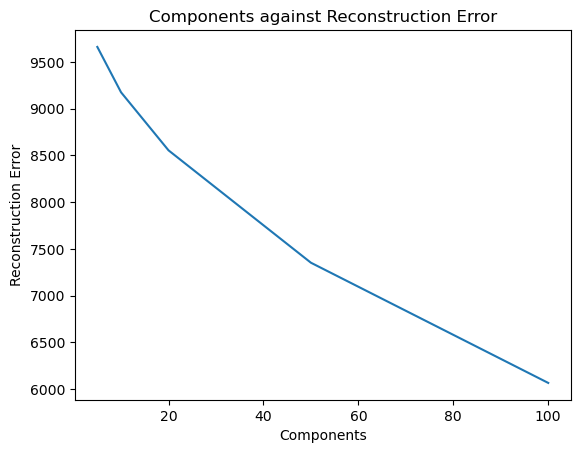

In [10]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.

reconstructions = []

for i in range(len(list_components)):
    W, H, reconstruction_error = nmf_nan(train_data, list_components[i], 100)
    reconstructions.append(reconstruction_error)

# Plot the final reconstruction error as a function of n_components
plt.plot(list_components, reconstructions)
plt.xlabel("Components")
plt.ylabel("Reconstruction Error")
plt.title("Components against Reconstruction Error")
plt.show()

In [11]:
W, H, reconstruction_error = nmf_nan(train_data, 100, 100)
X = np.matmul(W, H)

<h2>Computing Training Accuracies</h2>

We are now computing the training accuracies to compare different thresholds, if a value is below the threshold we do not recomment a user, if it is above, we recommend the user.

In [12]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...

list_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

accuracies = []

for c in range(len(list_components)):

    cur = []

    for t in range(len(list_thr)):

        # Compute training accuracy
        W, H, reconstruction_error = nmf_nan(train_data, list_components[c], 100)

        # reconstruct 
        X = np.matmul(W, H)
        a = (X >= list_thr[t]).astype(int)

        cur.append(np.sum(train_data == a))
    
    accuracies.append(cur)

In [13]:
accuracy = np.array(accuracies, dtype = float)
total = np.count_nonzero(~np.isnan(train_data))

accuracy = (accuracy / total) * 100

for i, c in enumerate(list_components):
    for j, t in enumerate(list_thr):
        print(f"For number of components: {c} and threshold: {t}\nAccuracy: {accuracy[i][j]:.2f}%\n")

For number of components: 5 and threshold: 0.2
Accuracy: 83.18%

For number of components: 5 and threshold: 0.4
Accuracy: 82.42%

For number of components: 5 and threshold: 0.6
Accuracy: 82.25%

For number of components: 5 and threshold: 0.8
Accuracy: 82.23%

For number of components: 5 and threshold: 1.0
Accuracy: 82.20%

For number of components: 10 and threshold: 0.2
Accuracy: 84.08%

For number of components: 10 and threshold: 0.4
Accuracy: 82.94%

For number of components: 10 and threshold: 0.6
Accuracy: 82.42%

For number of components: 10 and threshold: 0.8
Accuracy: 82.33%

For number of components: 10 and threshold: 1.0
Accuracy: 82.26%

For number of components: 20 and threshold: 0.2
Accuracy: 85.53%

For number of components: 20 and threshold: 0.4
Accuracy: 83.69%

For number of components: 20 and threshold: 0.6
Accuracy: 82.98%

For number of components: 20 and threshold: 0.8
Accuracy: 82.61%

For number of components: 20 and threshold: 1.0
Accuracy: 82.37%

For number of c

We will now repeat the same of the validation accuracies.

For the test data, we will use the best threshold and number of components from the validation data to evaluate the reconstruction.

In [14]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

list_thr2 = [0.1, 0.3, 0.5]

val_accuracies = []

for c in range(len(list_components)):

    cur = []

    for t in range(len(list_thr)):

        # Compute validation accuracy
        W, H, reconstruction_error = nmf_nan(train_data, list_components[c], 100)

        # reconstruct 
        X = np.matmul(W, H)
        a = (X >= list_thr[t]).astype(int)

        cur.append(np.sum(val_data == a))
    
    val_accuracies.append(cur)


In [16]:
val_accuracy = np.array(val_accuracies, dtype = float)
val_total = np.count_nonzero(~np.isnan(val_data))

val_accuracy = (val_accuracy / val_total) * 100
        
for i, c in enumerate(list_components):
    for j, t in enumerate(list_thr2):
        print(f"For number of components: {c} and threshold: {t}\nAccuracy: {val_accuracy[i][j]:.2f}%\n")

For number of components: 5 and threshold: 0.1
Accuracy: 82.87%

For number of components: 5 and threshold: 0.3
Accuracy: 82.75%

For number of components: 5 and threshold: 0.5
Accuracy: 82.70%

For number of components: 10 and threshold: 0.1
Accuracy: 83.16%

For number of components: 10 and threshold: 0.3
Accuracy: 82.75%

For number of components: 10 and threshold: 0.5
Accuracy: 82.71%

For number of components: 20 and threshold: 0.1
Accuracy: 83.17%

For number of components: 20 and threshold: 0.3
Accuracy: 82.78%

For number of components: 20 and threshold: 0.5
Accuracy: 82.70%

For number of components: 50 and threshold: 0.1
Accuracy: 83.08%

For number of components: 50 and threshold: 0.3
Accuracy: 82.79%

For number of components: 50 and threshold: 0.5
Accuracy: 82.70%

For number of components: 100 and threshold: 0.1
Accuracy: 83.05%

For number of components: 100 and threshold: 0.3
Accuracy: 82.72%

For number of components: 100 and threshold: 0.5
Accuracy: 82.69%



In [40]:
max_idx = np.argmax(val_accuracy)
row, col = np.unravel_index(max_idx, val_accuracy.shape)

comp = list_components[row]
thr = list_thr2[col]

In [41]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

W, H, reconstruction_error = nmf_nan(train_data, comp)

X = np.matmul(W, H)
a = (X >= thr).astype(int)
cur.append(np.sum(test_data == a))

# Compute test accuracy
test_accuracy = (np.sum(test_data == a) / np.count_nonzero(~np.isnan(test_data))) * 100

print(f"Test accuracy: {test_accuracy:g}%, thr: {thr:g}, n_components: {comp}")

Test accuracy: 78.711%, thr: 0.1, n_components: 20


## Distance-based recommender system

In [19]:
# defining our hash functions

h1 = HashFunction(2, 3)
h2 = HashFunction(4, 2)
h3 = HashFunction(1, 3)
h4 = HashFunction(3, 1)

hashes = [h1, h2, h3, h4]

<h2>Computing our row and column signature</h2>

Below, we have defined some functions to compute the signatures of the rows and columns of a given data set using min hashing.

In [71]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance

def compute_signature_row(hashes: list[HashFunction], data):
    row = []
    for i in range(data.shape[0]):

        # get current row of the data
        cur_row = data[i]
        # get indexes of where a "1" occurs
        a = np.argwhere(cur_row == 1)
        # convert to set and append to row list
        row.append(set(a.flatten()))
        
    return compute_signature(hashes, row)

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance

def compute_signature_col(hashes: list[HashFunction], data):

    col = []
    for i in range(data.shape[1]):
        

        # get current column of the data
        cur_col = data[:, i]
        # get indexes of where a "1" occurs
        a = np.argwhere(cur_col == 1)
        # convert to set and append to row list
        col.append(set(a.flatten()))
        
    return compute_signature(hashes, col) 

In [34]:
def jaccard_dis(a, b):
    a_set = set(a)
    b_set = set(b)

    return 1 - len(a_set.intersection(b_set)) / len(a_set.union(b_set))

<h2>Getting the nearest neighbours</h2>

For each user we are now finding the k users with similar preferences by calculating the Jaccard distance between their signatures.

In [74]:
def get_nearest_rows(sig_row, k : int):

    nearest = []

    for i in range(sig_row.shape[1]):
        distances = []
        for j in range(sig_row.shape[1]):
            if(i == j):
                continue

            # get all distances
            distances.append(jaccard_dis(sig_row[:, i], sig_row[:, j]))

        indexes = np.argsort(distances)

        nearest.append(indexes[:k])

    return np.array(nearest)

In [90]:
def get_nearest_cols(sig_col, k : int):
    nearest = []

    for i in range(sig_col.shape[1]):
        distances = []
        for j in range(sig_col.shape[1]):
            if(i == j):
                continue

            # get all distances
            distances.append(jaccard_dis(sig_col[:, i], sig_col[:, j]))

        indexes = np.argsort(distances)

        nearest.append(indexes[:k])

    return np.array(nearest)

<h2>Reconstructing the data</h2>

Now we can use the preferences of the nearest neigbours of a given user to either recommend or not recommend a date. This is done by majority vote.

In [102]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations

# reconstructing training data
def reconstruct_recommendations(data, nearest_rows):
  nr_users = data.shape[0]
  nr_items = data.shape[1]
  recommendations = np.zeros(data.shape)

  for u in range(nr_users):
    for i in range(nr_items):

      neighbours = nearest_rows[u]
      neighbour_choice = data[neighbours, i]
      nr_likes = np.sum(neighbour_choice == 1)
      nr_dislikes = np.sum(neighbour_choice == 0)

      if nr_likes >= nr_dislikes:
        recommendations[u, i] = 1
      elif nr_likes < nr_dislikes:
        recommendations[u, i] = 0

  return recommendations


In [92]:
def calculate_accuracy(data, pred):

    train_min = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i][j] == pred[i][j]):
                train_min += 1

    total = np.count_nonzero(~np.isnan(data))

    return train_min / total

Below, let us try reconstructing the training data and seeing its accuracy.

In [83]:
# start by computing row and column signatures for train data
train_row_sig = compute_signature_row(hashes, train_data)
train_col_sig = compute_signature_col(hashes, train_data)

# get nearest row and column neigbours
nearest_train_row  = get_nearest_rows(train_row_sig, 100)
nearest_train_col = get_nearest_cols(train_col_sig, 100)

# reconstruct our data
recon_train = reconstruct_recommendations(train_data, nearest_train_row)

# get accuracy of train data
acc_train_hash = calculate_accuracy(train_data, recon_train) * 100

print(f"Accuracy of train data with 100 nearest neigbours and all hashes: {acc_train_hash:g}%")

Accuracy of train data with 100 nearest neigbours and all hashes: 83.2339%


Let us now test out different hyperparameters to see which is the optimal for our validation data. We will then use the optimal hashes and k value to evaluate our reconstruction of the test data.

In [98]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)

# use multiple number of neighbours and hash function combinations
neighbours = [100, 500, 1000]
hash_func = [[h1], [h1, h2], [h1, h2, h3, h4]]
acc = np.zeros((len(neighbours), len(hash_func)))

for n in neighbours:
    for h in hash_func:

        row_sig = compute_signature_row(h, val_data)

        nearest_row  = get_nearest_rows(row_sig, n)

        # reconstruct our data
        recon_train = reconstruct_recommendations(val_data, nearest_row)

        # get accuracy of train data
        acc_hash = calculate_accuracy(val_data, recon_train) * 100

        print(f"For a nearest neighbour value of {n} and {len(h)} hashes, accuracy is: {acc_hash:g}%")
        
        acc[neighbours.index(n), hash_func.index(h)] = acc_hash

For a nearest neighbour value of 100 and 1 hashes, accuracy is: 84.795%
For a nearest neighbour value of 100 and 2 hashes, accuracy is: 85.4344%
For a nearest neighbour value of 100 and 4 hashes, accuracy is: 86.6525%
For a nearest neighbour value of 500 and 1 hashes, accuracy is: 83.8104%
For a nearest neighbour value of 500 and 2 hashes, accuracy is: 84.3585%
For a nearest neighbour value of 500 and 4 hashes, accuracy is: 85.201%
For a nearest neighbour value of 1000 and 1 hashes, accuracy is: 83.9525%
For a nearest neighbour value of 1000 and 2 hashes, accuracy is: 84.3281%
For a nearest neighbour value of 1000 and 4 hashes, accuracy is: 85.069%


In [101]:
# Report recommendation accuracy on the independent test data

# get index of best accuracy for validation set
max_index = np.unravel_index(np.argmax(acc), acc.shape)

row_sig = compute_signature_row(hash_func[max_index[1]], test_data)

nearest_row  = get_nearest_rows(row_sig, neighbours[max_index[0]])

# reconstruct our data
recon_train = reconstruct_recommendations(test_data, nearest_row)

# get accuracy of train data
acc_hash = calculate_accuracy(test_data, recon_train) * 100

print(f"For a nearest neighbour value of {neighbours[max_index[0]]} and {len(hash_func[max_index[1]])} hashes, accuracy is: {acc_hash:g}%")

For a nearest neighbour value of 100 and 4 hashes, accuracy is: 83.5601%
